# Detecting Bots in Covid-19 Tweets

In [50]:
from IPython.display import HTML, display
import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
%run ../aux/postgres.py

postgres functions loaded...


## Sets of Tweets in Portuguese and French

In [53]:
table = query("select codamostra, descricao, (select count(at.codtweet) from amostratweet at where at.codamostra = a.codamostra) from amostra a where lower(descricao) like '%covid%'")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

222,Covid-19 PT,12865843
223,Covid-19 FR,11861867


## Exporting tweets to csv:

~~~~
psql -d twitter -t -c "select json from tweet where codprojeto = 37 and datatweet between '2020-03-20' and '2020-04-09' and json->>'lang' = 'pt'"  > tweetspt.txt

psql -d twitter -t -c "select json from tweet where codprojeto = 37 and datatweet between '2020-03-20' and '2020-04-09' and json->>'lang' = 'fr'"  > tweetsfr.txt

mateus@kode:~/projetos/absa/20_corona/data$ wc -l tweetspt.txt
12.865.844 tweetspt.txt

mateus@kode:~/projetos/absa/20_corona/data$ wc -l tweetsfr.txt
11.861.868 tweetsfr.txt
~~~~

## SQL sets of tweets in Portuguese and French:

~~~~sql
INSERT INTO amostratweet (codamostra, codtweet) select 222, codtweet from tweet where codprojeto = 37 and datatweet between '2020-03-20' and '2020-04-09' and json->>'lang' = 'pt';

insert into amostratweet (codamostra, codtweet) select 223, codtweet from tweet where codprojeto = 37 and datatweet between '2020-03-20' and '2020-04-09' and json->>'lang' = 'fr';
~~~~

## Rule 01: users with more than 100 tweets in a single day

~~~~
psql -d twitter -t -c "SELECT userid, datatweet, count(t.codtweet) as tweets FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE at.codamostra = 222 GROUP BY userid, datatweet" > tweets_user_day_pt.csv

psql -d twitter -t -c "SELECT userid, datatweet, count(t.codtweet) as tweets FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE at.codamostra = 223 GROUP BY userid, datatweet" > tweets_user_day_fr.csv

~~~~


~~~~sql
insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 1, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE at.codamostra = 222 GROUP BY userid, datatweet having count(t.codtweet) >= 100;
insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 2, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE at.codamostra = 223 GROUP BY userid, datatweet having count(t.codtweet) >= 100;
~~~~

In [37]:
table = query("SELECT dbu.coddeteccaobot, db.descricao, count(*) as users FROM deteccaobotuserid dbu INNER JOIN deteccaobot db ON db.coddeteccaobot = dbu.coddeteccaobot WHERE db.descricao like 'Tweets por dia%' GROUP BY 1, 2")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

1,Tweets por dia pt,297
2,Tweets por dia fr,653


## Rule 02: user without profile image

222 - português
223 - francês
~~~~sql
insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 4, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE at.codamostra = 222 AND json->'user'->>'default_profile_image' = 'false';
insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 5, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE at.codamostra = 223 AND json->'user'->>'default_profile_image' = 'false';

~~~~

In [40]:
table = query("SELECT dbu.coddeteccaobot, db.descricao, count(*) as users FROM deteccaobotuserid dbu INNER JOIN deteccaobot db ON db.coddeteccaobot = dbu.coddeteccaobot WHERE db.descricao like 'Default Profile Image%' GROUP BY 1, 2")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

4,Default Profile Image pt,2203618
5,Default Profile Image fr,1340381


## Rule 03: followers count

~~~~sql
--- followers count
insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 6, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 and at.codamostra = 222 AND json->'user'->>'followers_count' = '0';

insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 7, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 and at.codamostra = 223 AND json->'user'->>'followers_count' = '0';  
~~~~

In [39]:
table = query("SELECT dbu.coddeteccaobot, db.descricao, count(*) as users FROM deteccaobotuserid dbu INNER JOIN deteccaobot db ON db.coddeteccaobot = dbu.coddeteccaobot WHERE db.descricao like 'Followers%' GROUP BY 1, 2")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

6,Followers count pt,38462
7,Followers count fr,35446


## Rule 04: friends count

~~~~sql
--- friends count
insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 8, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 and at.codamostra = 222 AND json->'user'->>'friends_count' = '0';

insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 9, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 and at.codamostra = 223 AND json->'user'->>'friends_count' = '0';  
~~~~

In [41]:
table = query("SELECT dbu.coddeteccaobot, db.descricao, count(*) as users FROM deteccaobotuserid dbu INNER JOIN deteccaobot db ON db.coddeteccaobot = dbu.coddeteccaobot WHERE db.descricao like 'Friends%' GROUP BY 1, 2")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

8,Friends count pt,9034
9,Friends count fr,10138


## Rule 05: difference betweet user creation date and tweet creation date

~~~~sql
--- created at
insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 10, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 and at.codamostra = 222 AND ((json->>'created_at')::date - (json->'user'->>'created_at')::date) <=7;

insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 11, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 and at.codamostra = 223 AND ((json->>'created_at')::date - (json->'user'->>'created_at')::date) <= 7;  
~~~~

In [42]:
table = query("SELECT dbu.coddeteccaobot, db.descricao, count(*) as users FROM deteccaobotuserid dbu INNER JOIN deteccaobot db ON db.coddeteccaobot = dbu.coddeteccaobot WHERE db.descricao like 'Create%' GROUP BY 1, 2")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

10,Created at pt,57924
11,Created at fr,34767


## Rule 06: tweet posted from non official client

~~~~sql

insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 16, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 and at.codamostra = 222 AND t.text not like '%twitter.com%>Twitter%';

insert into deteccaobotuserid (coddeteccaobot, userid) SELECT distinct 17, userid FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 and at.codamostra = 223 AND t.text not like '%twitter.com%>Twitter%';

~~~~

In [10]:
table = query("SELECT dbu.coddeteccaobot, db.descricao, count(*) as users FROM deteccaobotuserid dbu INNER JOIN deteccaobot db ON db.coddeteccaobot = dbu.coddeteccaobot WHERE db.descricao like 'Tweet Source%' GROUP BY 1, 2")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

16,Tweet Source pt,2203618
17,Tweet Source fr,1340381


## Rule 07: retweets

psql -d twitter -t -c "SELECT t.userid, count(t.codtweet) as retweets FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 AND at.codamostra = 222 AND lower(t.text) like 'rt%' GROUP BY 1" > user_retweets_pt.csv

psql -d twitter -t -c "SELECT t.userid, count(t.codtweet) as retweets FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 AND at.codamostra = 223 AND lower(t.text) like 'rt%' GROUP BY 1" > user_retweets_fr.csv

psql -d twitter -t -c "SELECT t.userid, count(t.codtweet) as tweets FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 AND at.codamostra = 222 GROUP BY 1" > user_tweets_pt.csv

psql -d twitter -t -c "SELECT t.userid, count(t.codtweet) as tweets FROM tweet t INNER JOIN amostratweet at ON at.codtweet = t.codtweet WHERE t.codprojeto = 37 AND at.codamostra = 223 GROUP BY 1" > user_tweets_fr.csv



In [14]:
!head data/user_retweets_pt.csv

 1000000000234049538 |        1
 1000000043833810945 |       10
 1000000052214009859 |        3
 1000000063198949377 |        1
 1000000069045772288 |        3
 1000000072539693057 |        1
 1000000155976945665 |        1
 1000000173131563008 |        1
 1000000203615866880 |        2
 1000000221928214528 |        1


In [26]:
!q -d'|' "select t1.c1, t1.c2, t2.c2, (100 * t1.c2 / t2.c2) from data/user_retweets_pt.csv t1 inner join data/user_tweets_pt.csv t2 on t1.c1 = t2.c1" > data/user_tweets_rts_pt.csv

In [28]:
!head data/user_tweets_rts_pt.csv

1000000000234049538|1|1|100
1000000043833810945|10|10|100
1000000052214009859|3|3|100
1000000063198949377|1|1|100
1000000069045772288|3|3|100
1000000072539693057|1|1|100
1000000155976945665|1|1|100
1000000173131563008|1|2|50
1000000203615866880|2|2|100
1000000221928214528|1|1|100


In [32]:
!wc -l data/user_tweets_rts_pt.csv

1704836 data/user_tweets_rts_pt.csv


In [70]:
# agrupando
!q -d'|' "select c4, count(c1) from data/user_tweets_rts_pt.csv group by c4 order by c4" > data/user_tweets_rts_pt_group.csv

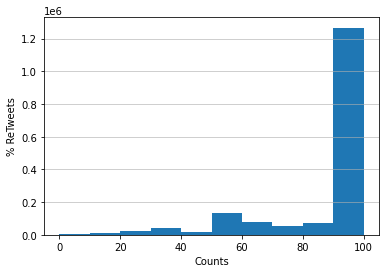

In [71]:
tweetsRts = pd.read_csv('data/user_tweets_rts_pt_group.csv',names=['tweets','counts'],delimiter='|')
plt.xlabel('Counts')
plt.ylabel('% ReTweets')
plt.hist(tweetsRts.tweets, weights=tweetsRts.counts)
plt.grid(axis='y', alpha=0.75)

In [29]:
!q -d'|' "select t1.c1, t1.c2, t2.c2, (100 * t1.c2 / t2.c2) from data/user_retweets_fr.csv t1 inner join data/user_tweets_fr.csv t2 on t1.c1 = t2.c1" > data/user_tweets_rts_fr.csv

In [30]:
!head data/user_tweets_rts_fr.csv

1000000135|3|3|100
1000000204685312001|1|1|100
1000000317151502336|4|4|100
1000000325695262720|1|1|100
1000000540829417472|19|19|100
1000000605082046465|5|5|100
1000000654566404096|2|2|100
1000000830072815616|1|2|50
1000000857407148033|2|2|100
1000000907231334400|2|3|66


In [31]:
!wc -l data/user_tweets_rts_fr.csv

1095929 data/user_tweets_rts_fr.csv


In [68]:
# agrupando
!q -d'|' "select c4, count(c1) from data/user_tweets_rts_fr.csv group by c4 order by c4" > data/user_tweets_rts_fr_group.csv

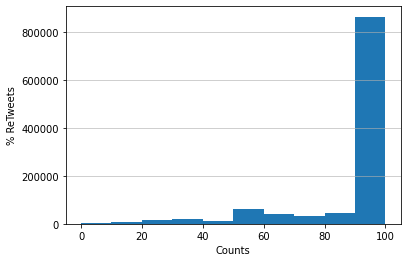

In [69]:
tweetsRts = pd.read_csv('data/user_tweets_rts_fr_group.csv',names=['tweets','counts'],delimiter='|')
plt.xlabel('Counts')
plt.ylabel('% ReTweets')
plt.hist(tweetsRts.tweets, weights=tweetsRts.counts)
plt.grid(axis='y', alpha=0.75)

# Rules Combination

## Users matching more than 3 rules
~~~~sql
insert into deteccaobotuserid (coddeteccaobot, userid) SELECT 12, userid from deteccaobotuserid where coddeteccaobot in (1, 4, 6, 8, 10) group by userid having count(*) >= 3;

insert into deteccaobotuserid (coddeteccaobot, userid) SELECT 14, userid from deteccaobotuserid where coddeteccaobot in (2, 5, 7, 9, 11) group by userid having count(*) >= 3;
~~~~

In [51]:
table = query("SELECT dbu.coddeteccaobot, db.descricao, count(*) as users FROM deteccaobotuserid dbu INNER JOIN deteccaobot db ON db.coddeteccaobot = dbu.coddeteccaobot WHERE db.descricao like 'Group by 3%' GROUP BY 1, 2")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

12,Group by 3 pt,19452
14,Group by 3 fr,17430


## Users matching more than 4 rules
~~~~sql
insert into deteccaobotuserid (coddeteccaobot, userid) SELECT 13, userid from deteccaobotuserid where coddeteccaobot in (1, 4, 6, 8, 10) group by userid having count(*) >= 4;

insert into deteccaobotuserid (coddeteccaobot, userid) SELECT 15, userid from deteccaobotuserid where coddeteccaobot in (2, 5, 7, 9, 11) group by userid having count(*) >= 4;
~~~~

In [52]:
table = query("SELECT dbu.coddeteccaobot, db.descricao, count(*) as users FROM deteccaobotuserid dbu INNER JOIN deteccaobot db ON db.coddeteccaobot = dbu.coddeteccaobot WHERE db.descricao like 'Group by 4%' GROUP BY 1, 2")
display(HTML(tabulate.tabulate(table, tablefmt='html')))

13,Group by 4 pt,2983
15,Group by 4 fr,3721


Antes de trabalhar nas tabelas dos tweets da covid, veja este email.
Penso que a sua idéia de focar nos usuários com mais de 100
tweets ao dia vai ser nosso foco.
Li um artigo que bots podem ter muitos seguidores e que muitas vezes
usam sim imagens de fundo e de perfil. Inclusive nas imagens de perfil
usam fotos de pessoas famosas.
Pelo que li os bots também retweetam bastante.
Assim, veja minha sugestão:
 - tomar os usuários com >100 tweets dia. Alguns até podem ser ok se responderem automaticamente perguntas de usuários;
 - analisar os "source" destes tweets;
 - analisar se retweetam bastante; e
 - continuar analisando a diferença de tempo entre a criação do perfil e
 do envio do tweet.

O que você acha?
Se formos seguir esta ou outra estratégia, precisamos pensar nas queries
que faremos no banco. Aí você me liga.
[]s,
Evandro

Veja o que já tinha postado antes:

Identify bots:

-    Many Twitter bots have a relatively recent creation date.

-    Many bot user names contain numbers, which can indicate automatic name generation.

-    The account primarily retweets content, rather than tweeting original content.

-    The account’s tweet frequency is higher than a human user could feasibly achieve.

-    The account may have a high number of followers and also be following a lot of accounts; conversely, some bot accounts are identifiable because they send a lot of tweets but only have a few followers.

-    Many bots tweet the same content as other users at roughly the same time. 

-    Short replies to other tweets can also indicate automated behavior.

-    There is often no biography, or indeed a photo, associated with bot Twitter accounts"




In [2]:
!ls data

corona1k.rds			    tweets_per_user.csv
corona.rds			    tweets_per_user_day.csv
count_max_tweets_user_day_lang.csv  tweetspt.txt
max_tweets_user_day_lang.csv	    tweets_user_day_fr.csv
sources.txt			    tweets_user_day_lang.csv
tweets1k.csv			    tweets_user_day_pt.csv
tweetsfr.txt


In [4]:
!head data/sources.txt

 <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>                                                              | 4178334
 <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>                                                            | 4125650
 <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>                                                                         | 2295725
 <a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>                                                               |  404984
 <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                                                                              |  296772
 <a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>                                                             |  113207
 <a href="http://publicize.wp.com/" rel="nofollow">WordPress.com</a>  

In [5]:
!wc -l data/sources.txt

2674 data/sources.txt
